# Image Analysis I (2023)

## Lab 3: Deep Learning & Pixelwise classification

__Enter your data:__


| Group __03__ | Name  | Matr.-nr. |
|-|-|-|
|   Member 1  | Chengliang Li | 10043349 |
|   Member 2  | Tingde Liu | 10050301 |
|   Member 3  | Yahui Zhang | 10050017 |

`In this lab, you will implement a Convolutional Neural Network (CNN) classifier and apply it to the MNIST dataset for image categorization. Then, you will build a semantic segmentation model using an encoder-decoder architecture and investigate some approaches for improving the classification results.`

__Libraries__ required for this lab can be installed by;
1. Visiting and following the instructions at [pytorch.org](https://pytorch.org/get-started/locally/) to see how __Pytorch__ and __Torchvision__ modules can be installed. The CUDA tab refers to the support of GPUs. Unless you have experience with the CUDA framework select `None` here.

2. Running ``!pip install segmentation-models-pytorch``. [__Segmentation-models-pytorch__](https://github.com/qubvel/segmentation_models.pytorch#installation) is a high level API for creating neural network with few lines of code.

Required __imports__ and __settings__ for this lab:

In [1]:
# IMPORTS
import lab                                       # Given functions
import numpy as np                               # Numerical computations
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib                                # Plots
import matplotlib.pyplot as plt    

import random
from functools import partial
from os.path import join as pjoin

import torch                                     # PyTorch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import transforms as TF
from torchvision.transforms import functional as TFF

import segmentation_models_pytorch as smp        #  Segmentation-models-pytorch

# GLOBAL SETTINGS
PlotSize = 7                                     # Size of plots
matplotlib.rcParams['figure.figsize'] = [PlotSize, PlotSize] 
CMAP = plt.cm.Accent                             # Color mapping 
np.set_printoptions(precision=3)                 # Array print precision
np.random.seed(0)

# Switch to CPU when GPU is not available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

print(device)

cuda


## Exercise 1: Image classification

We are going to use the  [MNIST dataset](http://yann.lecun.com/exdb/mnist/) alreadey used in the previous lab. The dataset contains images of hand written digits, each having 28 x 28 pixel and one channel. The classes correspond to the digits 0-9. The given function `lab.MnistGenerator()` will download the dataset (if not already available). The images in the MNIST dataset is already split into:

- 60.000 images for training
- 10.000 images for testing
- 1.000 images for validation

Run the next cell to visualize a few data samples from training. You can run the cell several times to see some digits:

Examples of digits:


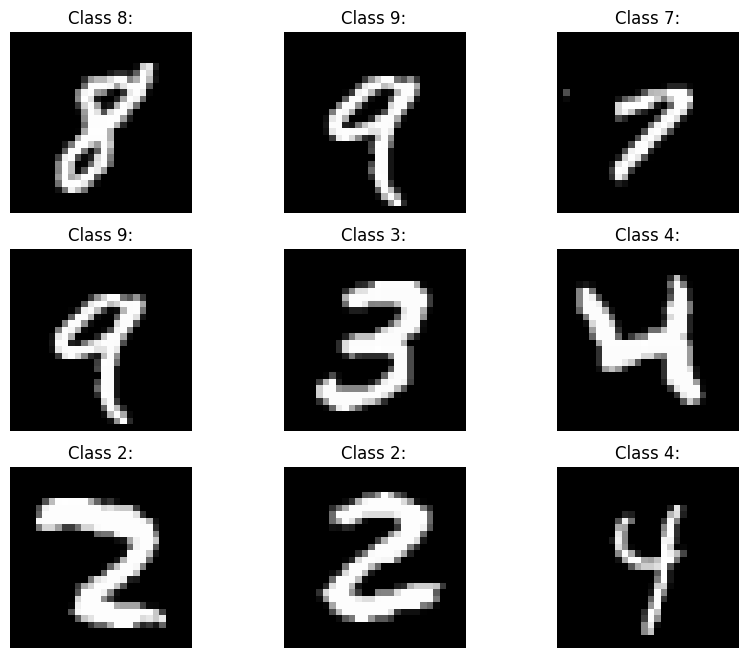

In [2]:
gen = lab.MnistGenerator()
Xs, Ys = gen.get_train_batch()

figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
print('Examples of digits:')

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(Xs), size=(1,)).item()
    img, label = Xs[sample_idx], Ys[sample_idx]
    title = "Class {}:".format(label)
    figure.add_subplot(rows, cols, i)
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Exercise 1.1: Defining the models

We will train the LeNet model on the dataset as described below:

__Convolutional neural network:__

- Implement the LeNet architecture
- For convolutions use `nn.Conv2d(...)`
- For max pooling use `F.max_pool2d(...)` (size is 2x2 and stride is also 2)
- Use `torch.relu` as non-linearity.


#### Hints:

- In each forward pass __normalize__ the images to a range of -1 to 1 (input values are in the range between 0 and 255).
- Use `x=x.view(-1, N)` to __flatten__ a feature map (with `N` elements). This is required when passing images or feature maps to dense (fully connected) layers.
- Take a look at the pytorch documentation about the usage of convolutions and pooling.
- __The last layer must not have a non-linearity__ (because the softmax is included in the loss formulation we will use later)
- The LeNet architecture is shown in the following image:

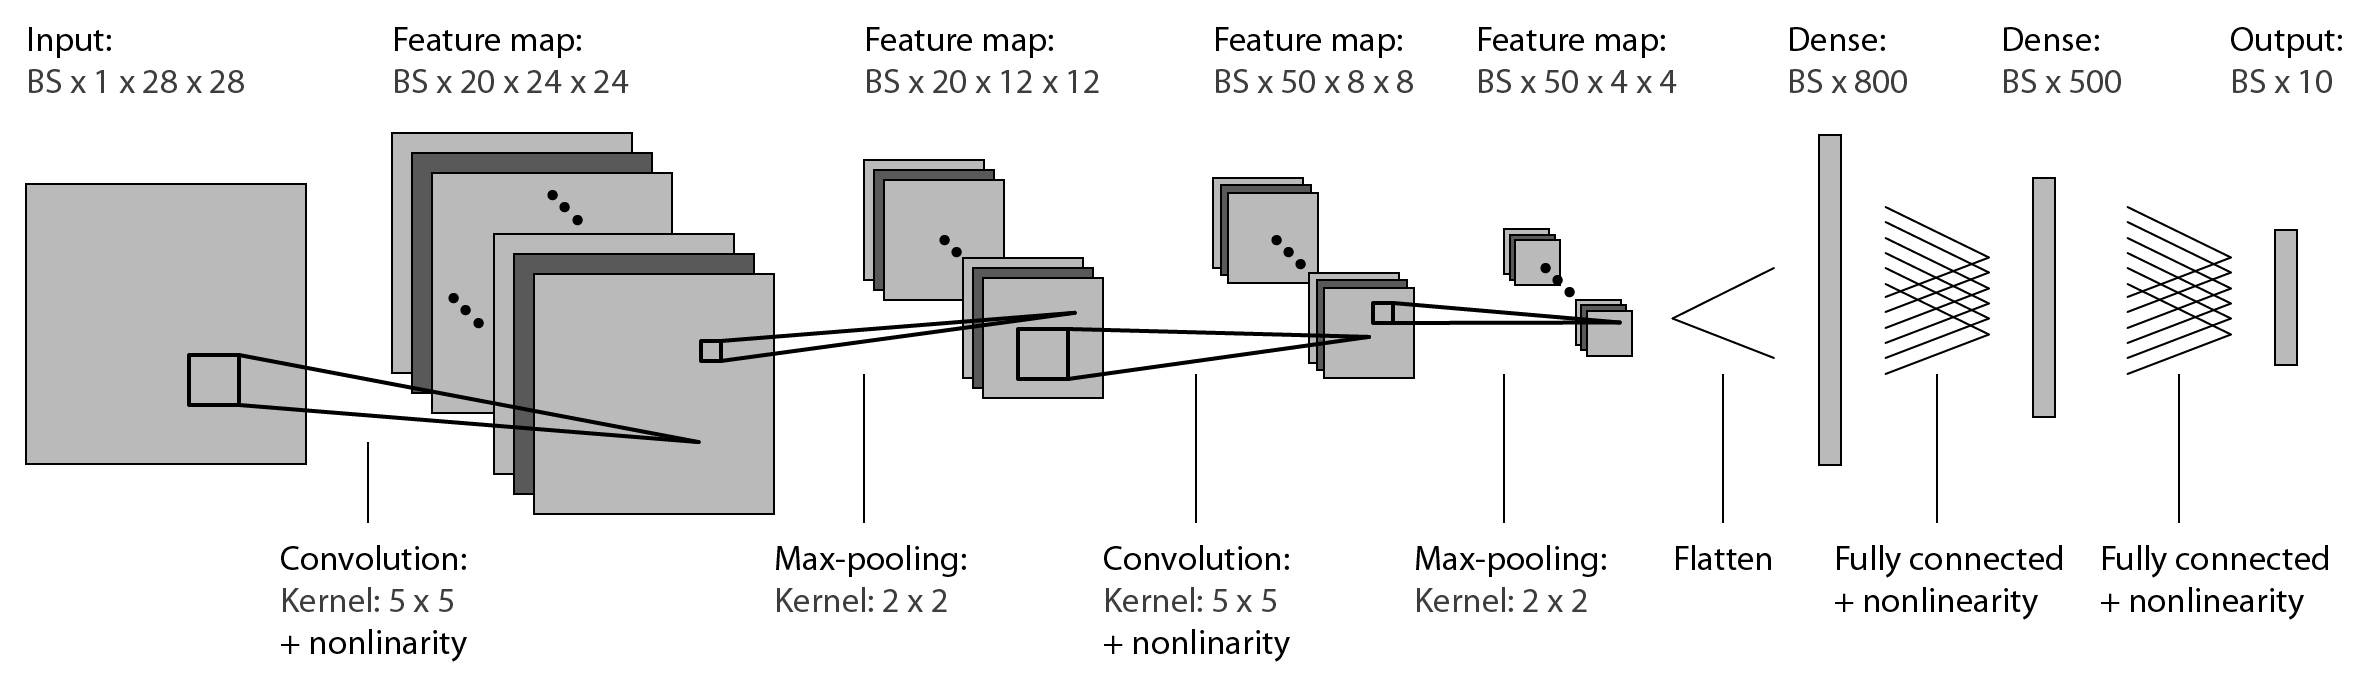

__Implement__ the model in the next cell. 


In [3]:
class LeNet(nn.Module):
    def __init__(self):
        
        # YOUR CODE GOES HERE
        
        super(LeNet,self).__init__()
        self.nol = nn.ReLU()                                #non-linearity

        self.fc1 = nn.Conv2d(1, 20, (5,5))
        self.fc2 = nn.Conv2d(20,50,(5,5))                   #nn.Conv2d(in_Channel,out_Channel,kernel_size)
        self.fc3 = nn.Linear(800,500)   
        self.fc4 = nn.Linear(500,10)

        
    def forward(self, x):
        
        # YOUR CODE GOES HERE
        
        x = (x/255)*2 - 1
        x = self.fc1(x)
        x = self.nol(x)                         
        x = F.max_pool2d(x,kernel_size=2,stride=2)         # max pooling

        x = self.fc2(x)
        x = self.nol(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2)         # max pooling

        x = x.view(-1,800)                                  # flatten

        x = self.fc3(x)
        x = self.nol(x)
        out = self.fc4(x)

        return out

#### Training loop

The training loop including evaluation on the validation and test sets is given in the next cell.

In [4]:
def train_network(gen, net, optimizer, num_iter):
    Ls = []     # Losses
    TBAs = []   # Training (Batch) Accuracy
    VAs = []    # Final Validation Accuracy
    
    net.train()
    criterion = nn.CrossEntropyLoss()
    
    for i in range(num_iter):
        X, Y = gen.get_train_batch()
        num_samples = float(len(Y))
        
        TX = torch.tensor(X).view(-1, 1, 28, 28)
        TY = torch.tensor(Y).long()
        
        optimizer.zero_grad()  
        pred = net(TX)
        loss = criterion(pred, TY)
        loss.backward()
        optimizer.step()  

        Vs, Is = torch.max(pred, -1)
        num_correct = np.sum(Is.data.numpy() == Y)
        TBA = num_correct/num_samples
        print('\rIt {}/{}, CE: {:.3f}, Batch Acc.: {}/{} = {:.1%}'.format(
            i, num_iter, loss.data, num_correct, len(Y), TBA), end='')
        
        # Compute accuracy of validation set
        
        X, Y = gen.get_validation_batch()
        num_samples = float(len(Y))
        TX = torch.tensor(X).view(-1, 1, 28, 28)
        TY = torch.tensor(Y).long()
        pred = net(TX)
        Vs, Is = torch.max(pred, -1)
        num_correct = np.sum(Is.data.numpy() == Y)
        VA = num_correct/num_samples
        
        Ls.append(float(loss.data))
        TBAs.append(TBA)
        VAs.append(VA)
        
    # Compute accuracy of test set
        
    X, Y = gen.get_test_batch()
    TX = torch.tensor(X).view(-1, 1, 28, 28)
    TY = torch.tensor(Y).long()
    pred = net(TX)
    Vs, Is = torch.max(pred, -1)

    CM = confusion_matrix(Y, Is)
    return Ls, TBAs, VAs, CM

### Exercise 1.2: Training

In the next cell,  the model is trained. __Choose appropriate hyperparameters__ to achieve stable results. In particular choose:

- Batch size `BS`
- Number of iterations `IT`
- Learning rate `LR`

#### Training LeNet

It 1999/2000, CE: 0.006, Batch Acc.: 20/20 = 100.0%
Final validation accuracy: 97.8%

TEST SET ACCURACY: 97.7%



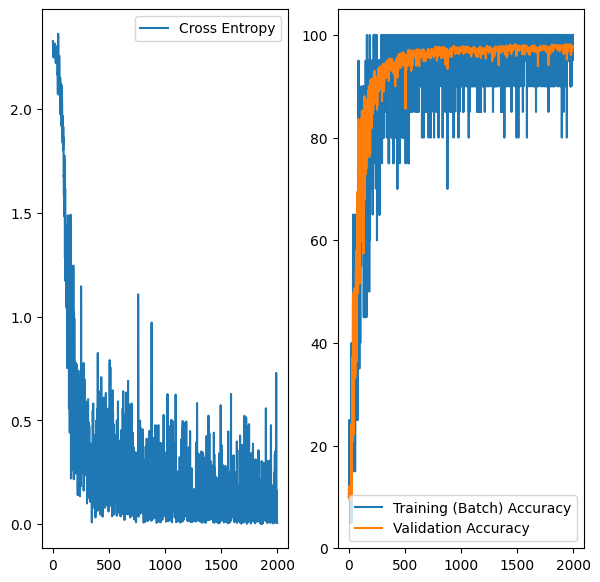

In [5]:
BS = 20
LR = 0.02
IT = 2000

gen = lab.MnistGenerator(BS) 
net = LeNet() 
optimizer = optim.SGD(net.parameters(), lr=LR)

Ls, TBAs, VAs, CM = train_network(gen, net, optimizer, IT)
lab.print_summary(Ls, TBAs, VAs, CM)

#### Training LeNet with few data
in the next setup, reduce the number of trainings samples until signs of overfitting are visible.

It 1999/2000, CE: 0.001, Batch Acc.: 20/20 = 100.0%
Final validation accuracy: 76.9%

TEST SET ACCURACY: 72.8%



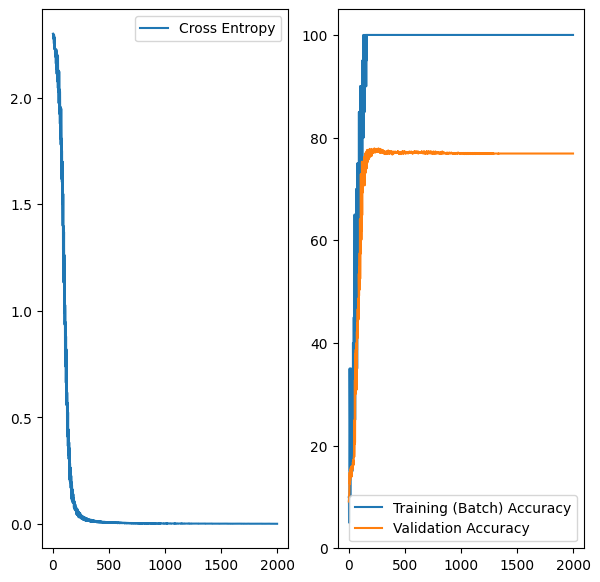

In [6]:
BS = 20
LR = 0.02
IT = 2000
num_training_samples = 60 # Try values in the range of  1-3 times the BS 

gen = lab.MnistGenerator(BS, num_train=num_training_samples) # Data generator
net = LeNet() 
optimizer = optim.SGD(net.parameters(), lr=LR)

Ls, TBAs, VAs, CM = train_network(gen, net, optimizer, IT)
lab.print_summary(Ls, TBAs, VAs, CM)

### Exercise 1.3: Discussion

__Write a discussion__ which answers the following questions: 

- What is the main influence of learning rate and batch size you could observe during the experiments?
- What can be observed when using too few training data? Which approaches exist to improve training with few samples? (That is, without modifying the hyper-parameters related to the training!)
- Why is the pooling operation used in LeNet? Name the two main reasons as well as an alternative approach for pooling.


*Do not forget to answer all questions, item by item, and to identify which answer belongs to which question.*

### Exercise 1.3: Discussion

__Write a discussion__ which answers the following questions: 

- What is the main influence of learning rate and batch size you could observe during the experiments?
- What can be observed when using too few training data? Which approaches exist to improve training with few samples? (That is, without modifying the hyper-parameters related to the training!)
- Why is the pooling operation used in LeNet? Name the two main reasons as well as an alternative approach for pooling.


*Do not forget to answer all questions, item by item, and to identify which answer belongs to which question.*

#### 1.What is the main influence of learning rate and batch size you could observe during the experiments? 
|Learning rate  | Validation accuracy | Test accuracy     |
| :---:        |    :----:   |          :---: |
| 10     | 9.8%      | 9.8%   |
| 1     | 9.8%      | 9.8%   |
| 0.1     | 97.3%      | 96.4%   |
| 0.02   | 98.0%        | 97.9%      |
| 0.01  | 97.2%       | 96.8%     |
        As the table shows as the learning rate gets smaller, the validation accuracy and test accuracy keep increasing. The test accuracy reaches its highest value 97.9% at a learning rate of 0.02. After that as the learning rate continues to get smaller, the the validation accuracy and test accuracy starts to decrease.The possible reasons could be：Learning rate controls the step size at which the model parameters are updated during training.This means that it can affect the speed of convergence and performance of the model. If the learning rate is too low, the model may converge very slowly, requiring a large number of iterations to reach good performance. If the learning rate is too high, the model may fail to converge or even diverge, resulting in unstable training and poor performance as shown in the table above.  
 |Batch size  | Validation accuracy | Test accuracy     |
| :---:        |    :----:   |          :---: |
|2000     | 97.8%      | 98.2%   |
| 1000     | 98.1%      | 98.2%   |
| 100     | 98.1%      | 98.0%   |
| 50    | 97.9%     | 97.6%   |
| 30     | 98.0%      | 97.5%   |
| 20   | 98.0%        | 97.7%      |
| 2   | 93.9%        | 94.8%      |
| 1  | 91.1%       | 90.1%     |      
        As the table shows as the batch size gets smaller, the validation accuracy and test accuracy keep decreasing.The possible reasons could be：Batch size determines the number of samples processed in each forward and backward pass during training. This means that it can also affect the speed of convergence and performance of the model. A larger batch size can speed up the training process as more samples are processed in parallel, and larger batch sizes can increase performance of the model as shown in the table above.
#### 2.What can be observed when using too few training data? Which approaches exist to improve training with few samples? (That is, without modifying the hyper-parameters related to the training!) 
|Trainings samples  | Validation accuracy | Test accuracy     |
| :---:        |    :----:   |          :---: |
| all  | 97.9%    | 97.5%   |
| 60   | 76.9%    | 72.8%   |
| 40   | 71.4%      |  64.8%     |
| 20  | 68.0%       | 62.4%     |
        When too little training data is used, the final validation accuracy and test accuracy can be low (60%-80%).As the table shows as the Trainings samples gets smaller, the validation accuracy and test accuracy keep decreasing. The possible reasons could be：With a limited amount of data, the model may start memorizing the training examples instead of learning general patterns, leading to overfitting. This means that the model will perform well on the training data but poorly on unseen data. We could improve the training with few samples by apply various data augmentation techniques to artificially increase the effective size of the training set. We could also apply regularization techniques like L1 or L2 regularization, or dropout. Regularization helps to prevent overfitting by adding penalties to the model's complexity.
#### 3.Why is the pooling operation used in LeNet? Name the two main reasons as well as an alternative approach for pooling.
       The first of main reasons is Translation Invariance. By summarizing local features and reducing spatial dimensions through pooling, the network becomes less sensitive to small spatial translations.
       The second of main reasons is Computational Efficiency. Pooling reduces the spatial dimensions of the input volume, resulting in a smaller number of parameters and computations in subsequent layers. By downsampling the feature maps, pooling reduces the model's memory footprint and computational complexity, making it more efficient during training and inference.
       An alternative approach to pooling is called "strided convolutions". Instead of using a separate pooling layer, strided convolutions directly downsample the feature maps by applying a convolutional layer with a stride greater than 1. This allows the network to learn the downsampling operation within the convolutional layers themselves, eliminating the need for an explicit pooling layer.

## Exercise 2: Pixelwise classification

In this exercise, we will use the [UAVID](https://uavid.nl/) dataset. It contains images of urban street scenes and is designed for semantic segmentation. The classes correspond to eight categories (Building, Road, Static car, Tree, Low vegetation, Human, Moving car and Background). The given function `lab.UaVidDataset()` will load the preprocessed dataset. The preprocessed images in the UAVID dataset are already split into:

- 140 images for training
- 70 images for validation
- 60 images for testing

Here are the steps to get the data into your working environment: 

- Click the link [UAVID processed data](https://seafile.projekt.uni-hannover.de/d/62046e1e87af435ab125/) to download the datasets.
- Copy both the __mini_uavid__ and __uavid_pkl__ folders to the root directory of the assignment where the __IAI_Lab_3.ipynb__ notebook is located.

__Lab assignment tree__ should look as follows:
```bash
├── IAI_Lab_3
│   ├── IAI_Lab_3.ipynb
│   ├── lab.py
│   ├── mini_uavid
│   ├── uavid_pkl
│   ├── images
│   └── checkpoints  # where the parameters of the models are saved

```

In the next cell, we define a colour code for the classes, and choose to ignore the class `Background (clutter)` for this exercise.

In [7]:
colours = np.array(
    [[128, 0, 0],   # Building
    [128, 64, 128], # Road
    [0, 128, 0],    # Tree
    [128, 128, 0],  # Low vegetation
    [64, 64, 0],    # Human
    [64, 0, 128],   # Moving car
    [192, 0, 192],  # Static car
    [0, 0, 0],      # Background (clutter)
])

class_names = ['Building', 'Road', 'Tree', 'Low vegetation', 'Human', 'Moving car', 'Static car']

num_cls   = 7       # number of classes
ign_index = 7       # ignore index (for this lab, 'Background (clutter)' is ignored)

# Function converts ID-maps to coloured label maps
def idmap2labelmap(idmap):
    h,w = idmap.shape[:2]
    labelmap = colours[idmap.reshape(-1)].reshape((h,w,3))
    return labelmap

__Run__ the following cell to load the preprocessed data for training, validation and testing


In [8]:
train_dataset    = lab.UaVidDataset('train')
val_dataset      = lab.UaVidDataset('val')
test_dataset     = lab.UaVidDataset('test')

print(f'Training samples   : {len(train_dataset)}')
print(f'Validation samples : {len(val_dataset)}')
print(f'Testing samples    : {len(test_dataset)}')

Training samples   : 140
Validation samples : 70
Testing samples    : 60


Let us randomly choose and visualize an example.

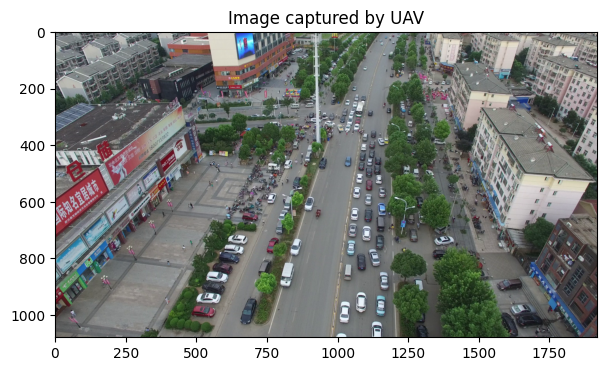

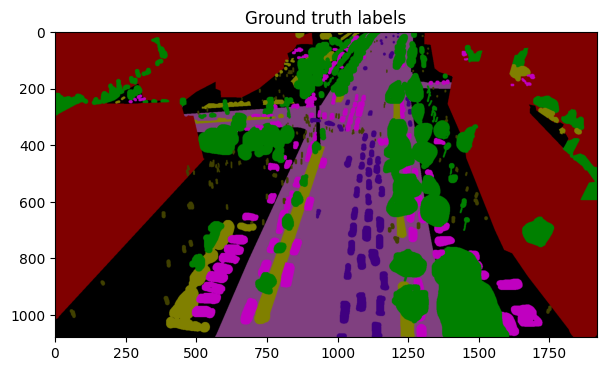

In [9]:
sample = train_dataset[3]
image, idmap = sample['image'], sample['idmap']
imgvisu = image.data.numpy().transpose(1,2,0)
labelmap = idmap2labelmap(idmap[0,:,:].data.numpy())

plt.imshow(imgvisu); plt.title('Image captured by UAV'); plt.show()
plt.imshow(labelmap); plt.title('Ground truth labels');  plt.show()

### Exercise 2.1: Defining a  UNet model from scratch

We will train 2 different models:

__1. Encoder - Decoder Neural network:__

- Implement the UNet architecture and use the module `DoubleConv(...)` for building blocks
- For max pooling use `F.max_pool2d(...)` (size is 2x2 and stride width is also 2)
- For up-sampling by bilinear interpolation use `F.interpolate (...)` (with 'bilinear' as interpolation mode and a scale factor of 2)
- Use the function `torch.cat(...)` for implementing skip connections by concatenating features from corresponding blocks in the encoder and the decoder).

__2. Encoder - Decoder Neural network without skip connections:__

- Simplify the UNet architecture by removing the skip connections between corresponding encoder and  decoder blocks (i.e., remove the concatenation of features from the encoder and the features of the decoder).

Here is an example of a "submodule" that is used several times in the actual UNet

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_chnls, out_chnls):
        super().__init__()
        Conv2d33 = partial(nn.Conv2d, kernel_size=3, padding=1)
    
        self.seq = nn.Sequential(Conv2d33(in_chnls, out_chnls), nn.ReLU(inplace=True),
                                Conv2d33(out_chnls, out_chnls), nn.ReLU(inplace=True))
    def forward(self, x):
        return self.seq(x)

Implementation of the UNet

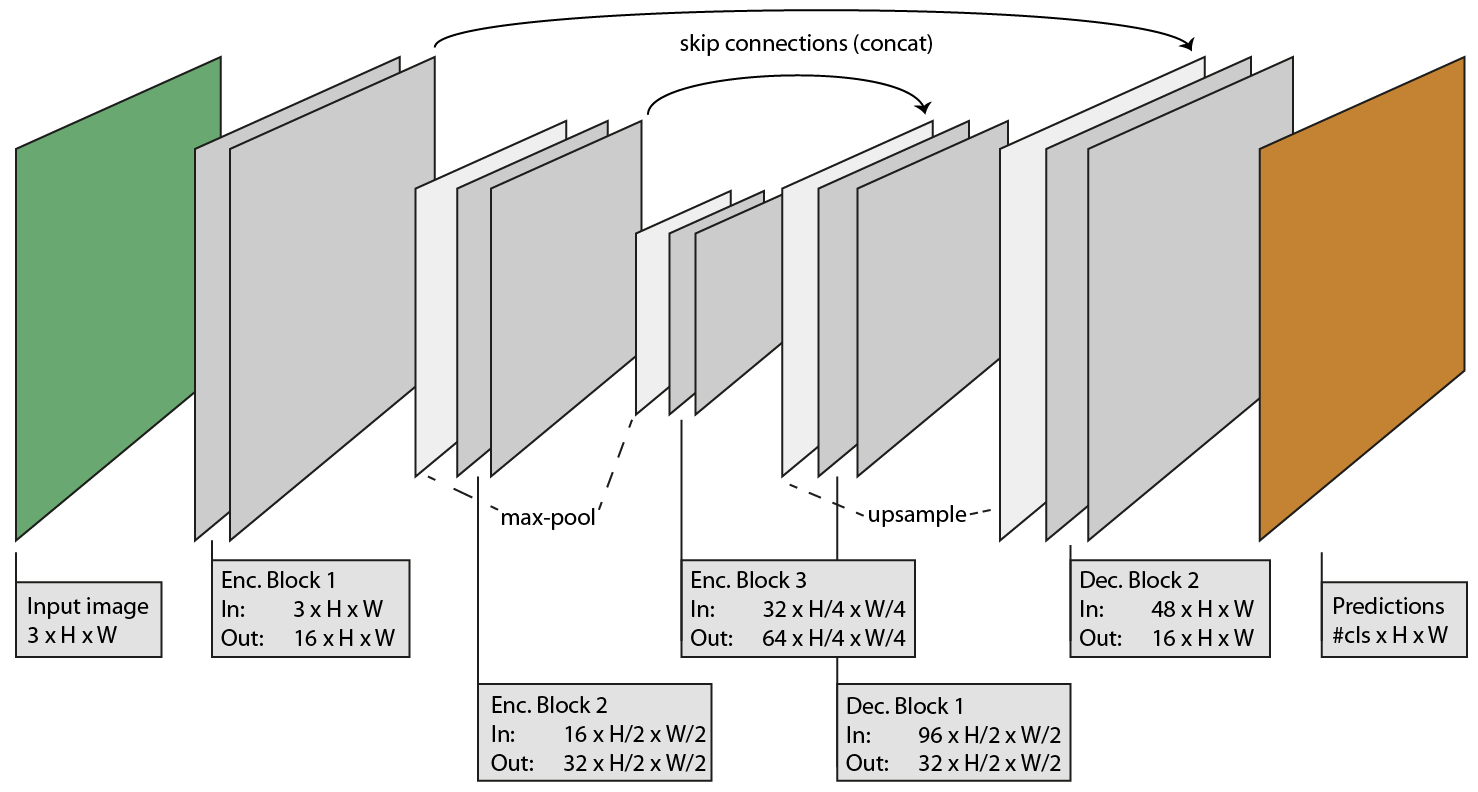

Use the next two cells to __implement__ the models 


In [11]:
# UNet model!

class UNet(nn.Module):
    def __init__(self, in_channels, num_cls):
        
        # YOUR CODE GOES HERE
        super().__init__()
        
        self.EncBlock1 = DoubleConv(in_channels, out_chnls=16)
        self.EncBlock2 = DoubleConv(in_chnls=16, out_chnls=32)
        self.EncBlock3 = DoubleConv(in_chnls=32, out_chnls=64)

        self.DecBlock1 = DoubleConv(in_chnls=96, out_chnls=32)
        self.DecBlock2 = DoubleConv(in_chnls=48, out_chnls=16)
        
        self.Out = nn.Conv2d(in_channels=16, out_channels=num_cls, kernel_size=1)
        

        
        
    def forward(self, x):
        
        # YOUR CODE GOES HERE
        max_pool2d_22  = partial(F.max_pool2d,  kernel_size=2, stride=2)
        interpolate_2b = partial(F.interpolate, scale_factor=2, mode='bilinear')

        EncBlock_x1 = self.EncBlock1(x)
        EncBlock_x2 = self.EncBlock2(max_pool2d_22(EncBlock_x1))
        EncBlock_x3 = self.EncBlock3(max_pool2d_22(EncBlock_x2))

        cat_x1 = torch.cat((EncBlock_x2, interpolate_2b(EncBlock_x3)), 1)
        DecBlock_x1 = self.DecBlock1(cat_x1)
        
        cat_x2 = torch.cat((EncBlock_x1, interpolate_2b(DecBlock_x1)), 1)
        DecBlock_x2 = self.DecBlock2(cat_x2)

        Out = self.Out(DecBlock_x2)

        return Out


In [12]:
# UNet model without skip connections!

class UnetWNoSC(nn.Module): 
    def __init__(self, in_channels, num_cls):
        
        # YOUR CODE GOES HERE
        super().__init__()
                
        self.EncBlock1 = DoubleConv(in_channels, out_chnls=16)
        self.EncBlock2 = DoubleConv(in_chnls=16, out_chnls=32)
        self.EncBlock3 = DoubleConv(in_chnls=32, out_chnls=64)

        self.DecBlock1 = DoubleConv(in_chnls=64, out_chnls=32)
        self.DecBlock2 = DoubleConv(in_chnls=32, out_chnls=16)

        self.Out = nn.Conv2d(in_channels=16, out_channels=num_cls, kernel_size=1)
        
    def forward(self, x):
        
        # YOUR CODE GOES HERE
        max_pool2d_22  = partial(F.max_pool2d,  kernel_size=2, stride=2)
        interpolate_2b = partial(F.interpolate, scale_factor=2, mode='bilinear')

        EncBlock_x1 = self.EncBlock1(x)
        EncBlock_x2 = self.EncBlock2(max_pool2d_22(EncBlock_x1))
        EncBlock_x3 = self.EncBlock3(max_pool2d_22(EncBlock_x2))

        DecBlock_x1 = self.DecBlock1(interpolate_2b(EncBlock_x3))
        DecBlock_x2 = self.DecBlock2(interpolate_2b(DecBlock_x1))

        Out = self.Out(DecBlock_x2)

        return Out



### Exercise 2.2: Training

__Complete__ the function `train_network()` where the UNet model is trained for `num_epochs` epochs using the Adam optimizer `optimizer` and a learning rate of `l_r`. After training has finished, the function should perform an evaluation based on the validation set, compute the confusion matrix and return the `current validation mean f1 score (mf1)`. Refer to the `lab.net_eval()` method and its associated functions to learn how to obtain the quality metrics from the confusion matrix.

By default, tensors are generated in the CPU. Even the model is initialized in the CPU. To allow the execution of a larger number of calculations in parallel, it is possible to opt for the use of the GPU. Therefore, our code has been adapted to use the GPU (if available) to make the neural network training much faster. For example, `image.to(device.type)` generate the tensor in the GPU if a GPU is available and in the CPU otherwise.

__Training Loop__

In [13]:
# training loop for a given number of epochs

def train_network(network, train_dataloader, val_dataloader, optimizer, num_epochs):
    
    max_val_score = 0.0
   
    # YOUR CODE GOES HERE!
    # Hint:
    #     loop over number of epochs

    #     Loss models are used to compute the loss, here: CrossEntropyLoss; 
    #     nn.CrossEntropyLoss(ignore_index=7) # Supervised loss

    #     print Training loss after each epoch
    #
    #    Compute accuracy on the validation set using the lab.eval_net()
    #    function, which can be found in the lab.py
    # 
    #
    for ep in range(num_epochs):
        print(f"Epoch {ep+1}")

        loss_fn = nn.CrossEntropyLoss(ignore_index=7)
        loss_record = []
        
        network.train()
        
        for batch in train_dataloader:
            
            image = batch['image'].to(device.type)
            idmap = batch['idmap'].to(device.type)

            optimizer.zero_grad()

            pred = network(image)
            loss = loss_fn(pred, idmap[0])

            loss.backward()
            optimizer.step()
            
            loss_record.append(loss.detach().item())
            # pass
        
        training_loss = sum(loss_record)/len(loss_record)
        print(f"Training Loss: {training_loss:>7f}")
        print("\n-------------------------------\n")

        mf1 = lab.eval_net(network, val_dataloader, metric='mf1')
        # print(mf1)
        
        # Optional: Save the best parameters of your trained model for further use
        if mf1 > max_val_score:
            print('New best parameters saved!')
            max_val_score = mf1
            model_name = network.name.lower()
            lab.save_net(network, f'{model_name}_val_{ep+1}')
        #     pass
        
        # pass
    print("\n")
    
    # return the mean f1 score
    return mf1

__Run__ the next cell to instantiate data loaders:

In [14]:
# Instantiation of the dataloaders for all subsets using PyTorch high-level API

train_dataloader = DataLoader(train_dataset,  num_workers=0, batch_size=1, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

#### Training UNet (without skip connections)
We will only do training for five epochs; this might take several minutes.

In [15]:
l_r           = 0.001 
num_epochs    = 5

# Instantiate the model
unet_w_no_sc = UnetWNoSC(3, num_cls) # 3 here is the number of channels for input image

# Set model name for saving best parameters 
unet_w_no_sc.name = 'UNET_WNoSC'

_ = unet_w_no_sc.to(device.type)

# Adam optimiser
optimiser =  optim.Adam(unet_w_no_sc.parameters(), lr=l_r) 

# Training
train_network(unet_w_no_sc, train_dataloader, val_dataloader, optimiser, num_epochs)

Epoch 1
Training Loss: 1.489295

-------------------------------


Running validation .. New best parameters saved!
Epoch 2
Training Loss: 1.420238

-------------------------------


Running validation .. Epoch 3
Training Loss: 1.364045

-------------------------------


Running validation .. New best parameters saved!
Epoch 4
Training Loss: 1.379529

-------------------------------


Running validation .. New best parameters saved!
Epoch 5
Training Loss: 1.174345

-------------------------------


Running validation .. 



0.17445191027388932

In [16]:
# Uncomment the next line (if you have already trained the model) to load the best saved params
# lab.load_net(unet_w_no_sc, 'unet_w_no_sc_val_5') # '5' here is the epoch

# Inference
f1s_unet_w_no_sc = lab.eval_net(unet_w_no_sc, test_dataloader, 'f1s')


Running validation .. 

#### Training UNet (with skip connections)

Learning rate and number of epochs should not be changed to make the experiment comparable to training without skip connections. Again, training for five epochs might take several minutes.

In [17]:
l_r           = 0.001 
num_epochs    = 5

# instantiate the model
unet = UNet(3, num_cls) # 3 here is the number of channels for the input image

# Set model name for saving best parameters 
unet.name = 'UNET'

_ = unet.to(device.type)

# Adam optimiser
optimiser = optim.Adam(unet.parameters(), lr=l_r) 

# Training
train_network(unet, train_dataloader, val_dataloader,  optimiser, num_epochs) 

Epoch 1
Training Loss: 1.489128

-------------------------------


Running validation .. New best parameters saved!
Epoch 2
Training Loss: 1.268740

-------------------------------


Running validation .. New best parameters saved!
Epoch 3
Training Loss: 1.134094

-------------------------------


Running validation .. New best parameters saved!
Epoch 4
Training Loss: 1.100359

-------------------------------


Running validation .. New best parameters saved!
Epoch 5
Training Loss: 1.048682

-------------------------------


Running validation .. 



0.18884218061087948

In [18]:
# Uncomment the next line (if you have already trained the model) to load the best saved params
# lab.load_net(unet, 'unet_val_5') # '5' here is the epoch

# Inference
f1s_unet = lab.eval_net(unet, test_dataloader, 'f1s')


Running validation .. 

__Run__ the next cell to visualize __predictions__ and display __F1-scores__ for each class for UNet without skip connections:

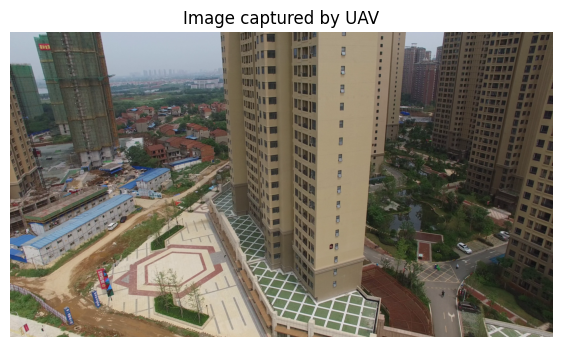

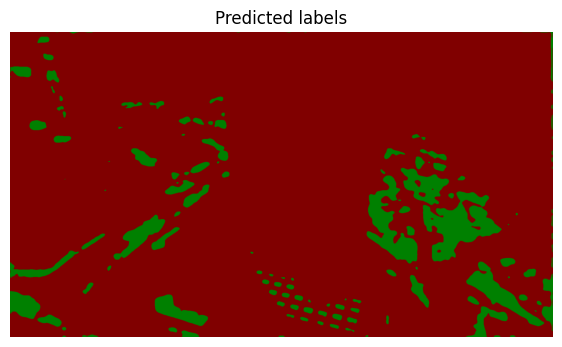

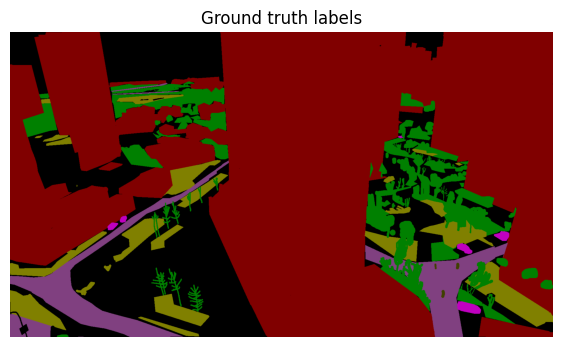

In [19]:
sample = val_dataset[15]
image, idmap = sample['image'], sample['idmap']
image_prep = image[np.newaxis,:,:,:].to(device.type)
pred = torch.argmax(unet_w_no_sc(image_prep), axis=1)

imgvisu = image.data.numpy().transpose(1,2,0)
labelmap = idmap2labelmap(idmap[0,:,:].data.numpy())
predvisu_unet_w_no_sc = idmap2labelmap(pred[0,:,:].cpu().data.numpy())

plt.imshow(imgvisu);  plt.title('Image captured by UAV');  plt.axis('off'); plt.show()
plt.imshow(predvisu_unet_w_no_sc); plt.title('Predicted labels'); plt.axis('off'); plt.show()
plt.imshow(labelmap); plt.title('Ground truth labels');   plt.axis('off'); plt.show()

In [20]:
print('F1-Scores')
for c_name, score in zip(class_names, f1s_unet_w_no_sc):
    print(f'{score:.2%} - {c_name}')
print(f'\nAverage f1s {np.mean(f1s_unet_w_no_sc):.2%}')

F1-Scores
54.77% - Building
0.00% - Road
32.96% - Tree
0.00% - Low vegetation
0.00% - Human
0.00% - Moving car
0.00% - Static car

Average f1s 12.53%


__Run__ the next cell to visualize __predictions__ and display __F1-scores__ for each class for UNet with skip connections:

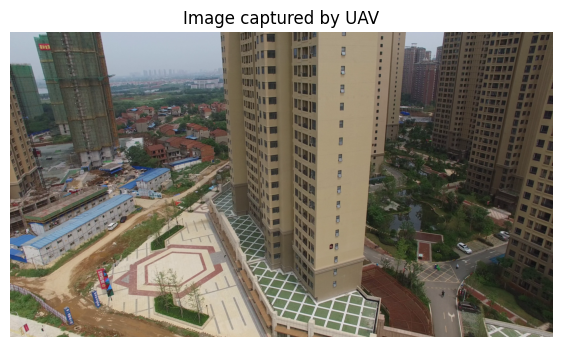

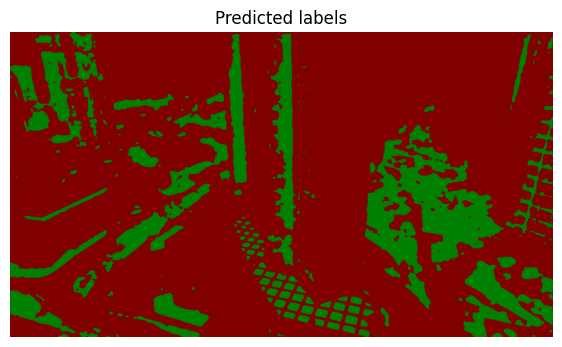

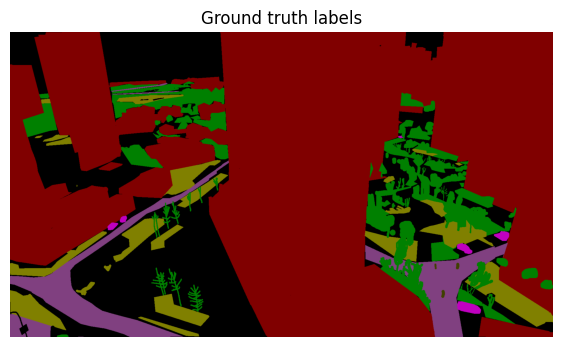

In [21]:
sample = val_dataset[15]
image, idmap = sample['image'], sample['idmap']
image_prep = image[np.newaxis,:,:,:].to(device.type)
pred = torch.argmax(unet(image_prep), axis=1)

imgvisu = image.data.numpy().transpose(1,2,0)
labelmap = idmap2labelmap(idmap[0,:,:].data.numpy())
predvisu_unet = idmap2labelmap(pred[0,:,:].cpu().data.numpy())

plt.imshow(imgvisu);   plt.title('Image captured by UAV'); plt.axis('off'); plt.show()
plt.imshow(predvisu_unet);  plt.title('Predicted labels'); plt.axis('off'); plt.show()
plt.imshow(labelmap); plt.title('Ground truth labels'); plt.axis('off'); plt.show()

In [22]:
print('F1-Scores')
for c_name, score in zip(class_names, f1s_unet):
    print(f'{score:.2%} - {c_name}')
print(f'\nAverage f1s {np.mean(f1s_unet):.2%}')

F1-Scores
59.63% - Building
0.00% - Road
43.29% - Tree
0.03% - Low vegetation
0.00% - Human
0.00% - Moving car
0.00% - Static car

Average f1s 14.71%


### Exercise 2.3: Discussion

__Write a discussion__ which answers the following questions: 

- Discuss the models' performance.
- What are the motivations for using skip connections?
- Which classes are problematic and why do you think this is the case?
- Describe two methods for changing the model architecture to help the CNN to generalize well.


##### 1. Discuss the models' performance.
|F1-Scores |Training UNet (without skip connections)  | Training UNet (with skip connections) |
|:---:     | :----: | :----:     | 
|Building    |  54.77%   | 59.63%  |        
|Road     | 0.03%    | 0.00%   |
|Tree      | 32.96%   | 43.29%  |
|Low vegetation | 0.00%    | 0.03%   |
|Human     | 0.00%   | 0.00%   |
|Moving car   | 0.00%    | 0.00%   |
|Static car    | 0.00%    | 0.00%   |
|Average f1s   | 12.53%   | 14.71%  |

From result we can see, the average F1-Scores of Unet with skip connections (14.71%) is better than Unet without skip connections  (12.53%).Unet with skip connections has better performance. The possible reasons could be： UNet with skip connections can better capture the contextual information between the encoder and decoder. But UNet with skip connections usually requires more memory and computing resources, because more feature maps need to be saved and processed. That means, Unet with skip connections requires more time than Unet without skip connections.  
In addition to this we can find that both models have a better performance for recognizing buildings and roads, but perform very poorly for other categories.The possible reasons could be：Buildings and roads make up a large percentage of the image, while the other categories are small in comparison.This means that the model has more training on buildings and roads（pixel） and therefore the model performs better in recognizing them.
##### 2. What are the motivations for using skip connections?
a. **Feature fusion of upsampling and downsampling:** Unet is a convolutional neural network architecture used for image segmentation. It consists of an encoder-decoder structure where the encoder captures low-level features through multiple downsampling operations, and the decoder gradually recovers the image resolution and captures higher-level semantic features through upsampling operations. With skip connections, the low-level features from the encoder can be directly passed to the corresponding layers in the decoder to be fused with high-level features. This feature fusion allows Unet to retain fine details and semantic information simultaneously during the segmentation process, which enhances its performance in segmentation tasks.  

b. **Mitigating information loss:** Information loss is a common problem in deep networks. As information propagates to deeper layers, the resolution of feature maps gradually decreases, leading to the loss of some fine details. Skip connections enable direct connections between early encoder features and decoder features, preserving high-resolution features from shallower layers and mitigating information loss.  

c. **Aiding gradient propagation:** Skip connections facilitate better gradient propagation throughout the network, improving training efficiency and stability. During backpropagation, gradients can flow directly through skip connections to early layers, avoiding the vanishing gradient problem and promoting faster convergence.

#### 3. Which classes are problematic and why do you think this is the case?
In the current situation, all categories have issues. The model can only differentiate between buildings and trees but fails to distinguish other classes.

The possible reason is that the model's training iterations are not enough, because we training 5 times here, resulting in the model not fully fitting the data. In other words, the model is underfitting, failed to capture enough features to effectively differentiate between different categories.
#### 4. Describe two methods for changing the model architecture to help the CNN to generalize well.
a. Increasing model depth and width: Deeper networks allow the model to capture more abstract and complex features from the input data. Widening the network refers to adding more channels or neurons in each layer, enabling the model to learn more diverse data representations. However, increasing depth or width may lead to more complex models that may require more data to prevent overfitting.  

b. Adjusting the convolutional kernel size: Modifying the size of the convolutional kernels can influence the model's perception range for different features. Smaller kernels can capture local features, while larger kernels can capture more global features. By using different kernel sizes at various layers, the model can perceive features at multiple scales, thus enhancing its generalization capability.

## Exercise 3. Improving the classifier

### Exercise 3.1:  Data augmentation


The Pytorch framework provides a flexible way to perform image transformations through its module __torchvision.transforms__ (check https://pytorch.org/vision/stable/transforms.html for more details). Run the next cell to apply some transformations to the images:  

In [23]:
# Adjust the brightness and contrast of the image
def augmentation_radiometric(sample):
    image, idmap = sample['image'], sample['idmap']

    image = TFF.adjust_brightness(image, brightness_factor = random.randint(8, 12)/10.0)
    image = TFF.adjust_contrast(image, contrast_factor = random.randint(8, 12)/10.0)
    
    return {'image':image, 'idmap':idmap}


# Rotate the image by angle
def augmentation_geometric(sample):
    image, idmap = sample['image'], sample['idmap']

    angle = random.randint(-10, 10)
    image = TFF.rotate(image, angle)
    idmap = TFF.rotate(idmap, angle, fill=ign_index)
    
    if random.random() > 0.5:
        image = TFF.hflip(image)
        idmap = TFF.hflip(idmap)
        
    h,w = image.size()[1:]
    ph = h - h%32
    pw = w - w%32
    
    cx = random.randint(0, h-ph)
    cy = random.randint(0, w-pw)
    
    image = TFF.crop(image, cx, cy, ph, pw)
    idmap = TFF.crop(idmap, cx, cy, ph, pw)
        
    return {'image':image, 'idmap':idmap}

In [24]:
# Putting the two transformations into a single function
def augmentation(sample):
    sample = augmentation_geometric(sample)
    sample = augmentation_radiometric(sample)
    return sample

# Upper left cropping
def upper_left_crop(sample):
    image, idmap = sample['image'], sample['idmap']

    h,w = image.size()[1:]
    ph = h - h%32
    pw = w - w%32
    
    image = TFF.crop(image, 0, 0, ph, pw)
    idmap = TFF.crop(idmap, 0, 0, ph, pw)
        
    return {'image':image, 'idmap':idmap}

In the next cell, __apply__ the `augmentation()` function on the training data and the function `upper_left_crop()`  to both validation and testing sets to __INITIALISE loaders__. Remender to set `shuffle=True` for the training set to opt to shuffle the data during each epoch.

In [25]:
# YOUR CODE GOES HERE!

# Hints: Refer to how we instantiated data samples for training UNet
      # 1. Apply the augmentation to the training samples
      # 2. Apply the upper left cropping to the validation samples
      # 3. Apply the upper left cropping to the test samples

train_dataset_aug = [augmentation(sample) for sample in train_dataset]
val_dataset_crop  = [upper_left_crop(sample) for sample in val_dataset]
test_dataset_crop = [upper_left_crop(sample) for sample in test_dataset]

train_dataloader_aug = DataLoader(train_dataset_aug, num_workers=0, batch_size=1, shuffle=True)
val_dataloader_crop  = DataLoader(val_dataset_crop, batch_size=1, shuffle=False)
test_dataloader_crop = DataLoader(test_dataset_crop, batch_size=1, shuffle=False)


__Run__ the next cell to check your loaders with augmentation.

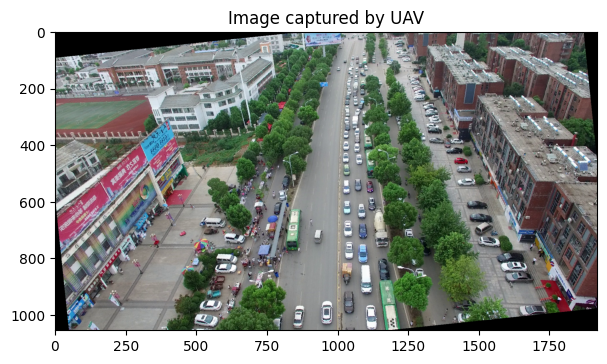

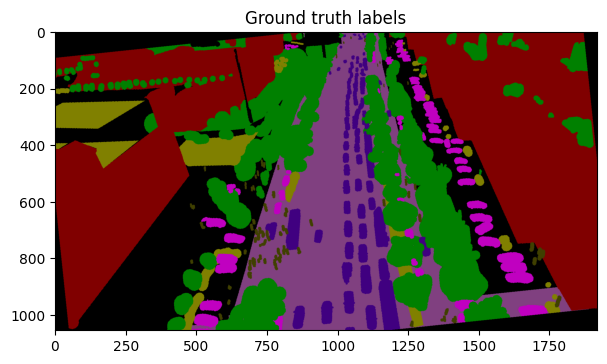

In [26]:
sample = train_dataset_aug[0]
image, idmap = sample['image'], sample['idmap']

imgvisu = image.data.numpy().transpose(1,2,0)
labelmap = idmap2labelmap(idmap[0,:,:].data.numpy())
plt.title('Image captured by UAV')
plt.imshow(imgvisu)
plt.show()
plt.title('Ground truth labels')
plt.imshow(labelmap)

### Exercise 3.2: Training the new classifier

One way to improve the accuracy of the classification is to use a powerful model. In this section, a pre-trained model is trained. __Run__ the next two cells to load and train the model for __2 epochs__ (otherwise this would take too long). 

Load a __stronger__ and __pre-trained__ backbone model. The model loaded here is a UNet model with an X-Ception backbone defined in [pretrainedmodels](https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/xception.py#L114):

In [30]:
import ssl

# Fixing URLError when loading pre-trained weights!
ssl._create_default_https_context = ssl._create_unverified_context

depth = 5
unet_pt = smp.Unet('xception', in_channels=3, classes=7, encoder_depth=depth,
                             decoder_channels=[256, 128, 64, 32, 16][-depth:], encoder_weights='imagenet')
# Set model name
unet_pt.name = 'UNET_PT'

_ = unet_pt.to(device.type)

In [32]:
LR = 0.01
M  = 0.9
WD = 0.0
num_epochs =  2

# Here SGD is used, because the backbone was pre-trained with SGD as well
optimiser = optim.SGD(unet_pt.parameters(), lr=LR, momentum=M, weight_decay=WD)

# Train dataloader should be the one with augmentation and val_dataloader with cropping
train_network(unet_pt, train_dataloader_aug, val_dataloader_crop, optimiser, num_epochs)

Epoch 1
Training Loss: 0.345342

-------------------------------


Running validation .. New best parameters saved!
Epoch 2
Training Loss: 0.278345

-------------------------------


Running validation .. New best parameters saved!




0.6065163428173862

Now that you know how to re-train a pre-trained model, use the following link [to download pre-trained parameters](https://seafile.projekt.uni-hannover.de/f/063a431933cc477c988c/). The file `unet_pt_val_78.pt` __should be placed in the `checkpoints` folder__ where this notebook is run. 

The next cell will load those pre-trained weights and run inference on the test set:

In [33]:

# Load the pre-trained params
lab.load_net(unet_pt, f'unet_pt_val_78')

# Inference
f1s_unet_pt = lab.eval_net(unet_pt, test_dataloader_crop, 'f1s')


Running validation .. 

#### Visualising prediction

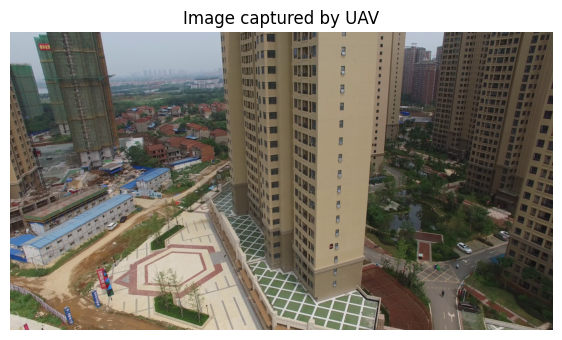

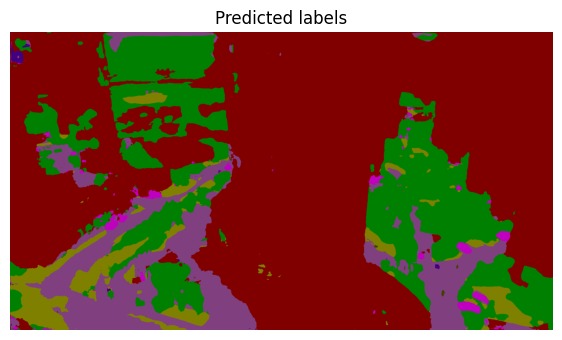

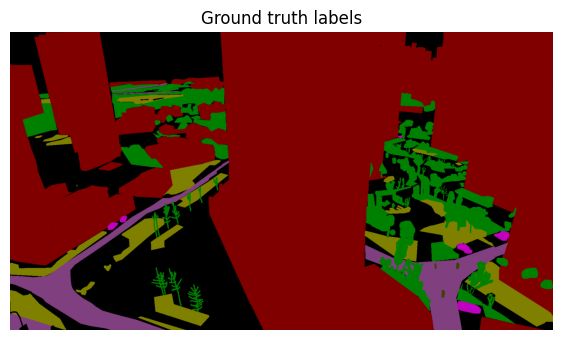

In [34]:
sample = val_dataset_crop[15]
image, idmap = sample['image'], sample['idmap']

image_prep = image[np.newaxis,:,:,:].to(device.type)
pred = torch.argmax(unet_pt(image_prep), axis=1)
imgvisu = image.data.numpy().transpose(1,2,0)
labelmap = idmap2labelmap(idmap[0,:,:].data.numpy())
predvisu_unet_pt = idmap2labelmap(pred[0,:,:].cpu().data.numpy())

plt.imshow(imgvisu); plt.title('Image captured by UAV');  plt.axis('off'); plt.show()
plt.imshow(predvisu_unet_pt); plt.title('Predicted labels'); plt.axis('off'); plt.show()
plt.imshow(labelmap); plt.title('Ground truth labels'); plt.axis('off'); plt.show()

__Run__ the next cell to display __F1-scores__ for each class for UNet  pretrained

In [35]:
print('F1-Scores')
for c_name, score in zip(class_names, f1s_unet_pt):
    print(f'{score:.2%} - {c_name}')
print(f'\nAverage f1s {np.mean(f1s_unet_pt):.2%}')

F1-Scores
85.47% - Building
84.58% - Road
69.99% - Tree
63.52% - Low vegetation
29.63% - Human
69.12% - Moving car
42.48% - Static car

Average f1s 63.54%


Visual comparison to basic UNet

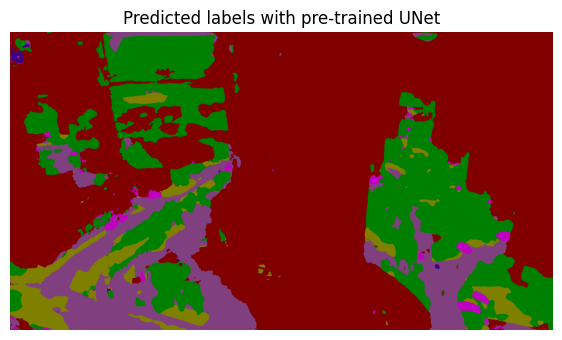

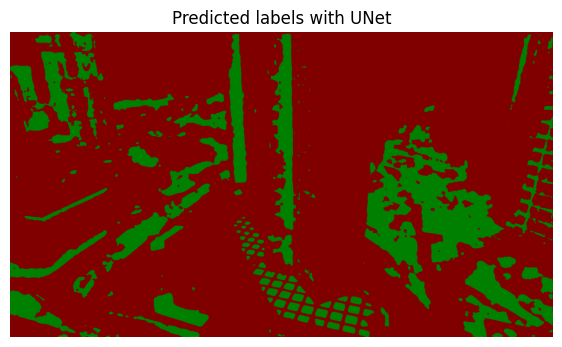

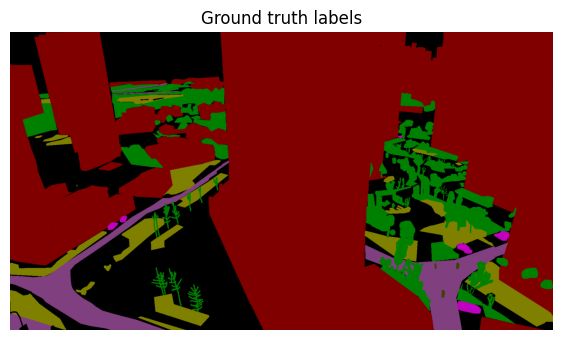

In [36]:
plt.imshow(predvisu_unet_pt); plt.title('Predicted labels with pre-trained UNet'); plt.axis('off'); plt.show() 
plt.imshow(predvisu_unet);  plt.title('Predicted labels with UNet'); plt.axis('off'); plt.show()
plt.imshow(labelmap); plt.title('Ground truth labels'); plt.axis('off'); plt.show()

### Exercise 3.3: Discussion

__Write a discussion__ which answers the following questions: 

- What is the purpose of using data augmentation  when training a Neural network? Are there any other data augmentation techniques (not implemented here) you think might be useful for this exercise? Why do you think this would be the case?
- What do we expect when applying pre-trained networks? 

*Do not forget to answer all questions, item by item, and to identify which answer belongs to which question.*

#### 1. What is the purpose of using data augmentation  when training a Neural network? Are there any other data augmentation techniques (not implemented here) you think might be useful for this exercise? Why do you think this would be the case?
    - Training deep learning models requires a large amount of data, and insufficient training data is a common problem. If there is a lack of training data, the model may struggle to converge, as a small amount of data may not provide enough information for the model to learn effectively. Additionally, it can lead to issues such as getting stuck in local minimum values. Therefore, data augmentation is used to artificially increase the diversity and variability of the training data. By applying a series of transformations or modifications to the existing data, new versions that are slightly altered based on the original data are created, thereby enlarging the dataset and improving the model's performance. Correctly using data augmentation can bring the following benefits:

        1. Reducing the cost of data collection and labeling.
        2. Improving model generalization by providing more diversity and flexibility.
        3. Enhancing the accuracy of predictions as the model is trained on a larger and more diverse dataset.
        4. Reducing data overfitting.

    In this lab, we adjust the brightness and contrast of the images and perform cropping. Additionally, the following two techniques can be used for this dataset:

        1.Adding random noise: Adding random noise to the images, such as Gaussian noise or salt-and-pepper noise, can make the model more robust to noise in the images. This can help the model generalize better to real-world scenarios where images may contain various types of noise.

        2. Applying scale transformations: By changing the aspect ratio of the images, we can introduce more variations and simulate different perspectives. Scaling the images to different sizes can provide additional diversity in the dataset and help the model learn to recognize objects at different scales.

#### 2. What do we expect when applying pre-trained networks? 
    - There are several reasons for applying pre-trained models in deep learning training:
      - 1. Saving training time and computational resources: To achieve good results in deep learning models, extensive training on large-scale datasets is required. This not only demands days or weeks of training time but also relies on sufficient hardware resources, such as high-performance GPUs. By loading pre-trained models and fine-tuning them for the specific task or continuing training from that point, it is possible to obtain good-performance models in a relatively shorter time. For example, in this lab, training the unet_pt network for 2 epochs on my computer (CPU-based training, because I didn’t have GPU) takes 1 hour. If I were to train it for 78 epochs, it would consume a significant amount of time. However, I can save a lot of time by loading an existing pre-trained model.
      - 2. Addressing data scarcity issues: In certain specialized tasks, the available training data may be limited or it might be challenging to acquire high-quality datasets. Training a model from scratch with such limited data can lead to underfitting. By utilizing pre-trained models trained on similar large datasets, it is possible to improve model performance by leveraging prior knowledge and accelerate the learning and generalization process for the target task.
      - 3. Facilitating academic communication and performance comparison: New models are being built and trained constantly worldwide. Without pre-trained models, it would require a significant amount of time to construct multiple models and train them in order to perform various model tests for a specific task before any comparison can be made. However, by using pre-trained models, the process of comparison becomes much simpler. It allows for straightforward comparisons not only between different models but also between the same model at different training iterations. For example, We can use the torchvision.models in PyTorch to download pre-trained models. This module provides many commonly used pre-trained models such as ResNet, VGG, AlexNet, etc.

**That's all we've done for the last lab3. We hope you enjoy reading it. By the way, thank you for your serious comments on each of our assignments. Thank you for your serious and patient responses to each of our questions. You are a wonderful teaching assistants！** :)